In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.layers import Dropout, Dense 
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import tensorflow as tf 
import spacy 
import os 
import keras 
import random 
import seaborn as sns 
import pandas as pd 
import string
import nltk
import numpy as np 
import re 
sns.set_style('darkgrid')

In [97]:
def reproduce():
    os.environ['PYTHONHASHSEED'] = str(42)
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

In [98]:
# load stopwords 
stop_words = set(stopwords.words('english'))

In [99]:
# load positive words 
pos = []
with open('positive-words.txt','r') as file:
    for line in file.readlines():
        word = re.match('[^;]*\n',line)
        if word:
            x = word.group().strip()
            if x :
                pos.append(x)
    file.close()
# load negative words
neg = []
with open('negative-words.txt','r') as file:
    for line in file.readlines():
        word = re.match('[^;]*\n',line)
        if word:
            x = word.group().strip()
            if x :
                neg.append(x)
    file.close()
# load stop words 
stopText = []
with open('stop.txt','r') as file:
    for line in file.readlines():
        if line.strip():
            stopText.append(line.strip())

In [100]:
# load dataset 
data = pd.read_csv('Elon_musk.csv',encoding='cp1252')
data.drop(data.columns[0],inplace=True,axis=1)
data.head(20)

,Text
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...
9,The most entertaining outcome is the most likely


In [101]:
# check for duplicate rows 
if data.duplicated().sum():
    print(f'No. of duplicate rows : {data.duplicated().sum()}')
    print(data[data.duplicated()])
else :
    print('duplicates already dropped')

No. of duplicate rows : 2
                                                 Text
324  The most entertaining outcome is the most likely
655                             @westcoastbill Indeed


In [102]:
# drop duplicated rows 
data.drop_duplicates(inplace=True)
print(f'No. of duplicate rows : {data.duplicated().sum()}')

No. of duplicate rows : 0


In [103]:
# text cleaning 
def clean_text(text):
    # remove tags 
    text = re.sub('@[^\s^:]*','',text)
    # remove emojis unicode
    text = re.sub('(<[A-Z0-9\+]*>)','',text)
    # remove links
    text = re.sub('(https|http)://[.\w/]*','',text)
    # remove numbers
    text = re.sub('[0-9]','',text).strip()
    text = text.lower()
    # tokenize text 
    tokens = nltk.word_tokenize(text)
    # removing stopwords
    text = ' '.join([x.strip() for x in tokens if x not in set(stopText)])
    # removing punctuations 
    text = text.translate(str.maketrans('','',string.punctuation)).replace('’','').replace('“','').replace('”','').replace('…','')
    # initialize lemmatizer 
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma = []
    for word in nltk.word_tokenize(text):
        pos = nltk.pos_tag([word])[0][-1]
        if pos.startswith('V'):
            lemm_tag = wordnet.VERB
        elif pos.startswith('N'):
            lemm_tag = wordnet.NOUN
        else :
            lemm_tag = wordnet.ADJ
        lemma.append(lemmatizer.lemmatize(word,lemm_tag))
    text = ' '.join(lemma)
    return text.strip()

In [104]:
# adding clean text in 'cleaned_text' column
data['cleaned_text'] = data.Text.apply(clean_text)
data.head(10)

,Text,cleaned_text
0,@kunalb11 I’m an alien,alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray trace cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulation tesla china amaze execution year
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,happy year ox
6,"Frodo was the underdoge,\nAll thought he would...",frodo underdoge thought fail
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),haha
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,tweet represent realworld time allocation
9,The most entertaining outcome is the most likely,entertain outcome


In [105]:
# cleaned text column with empty string
print(f'No. of rows in cleaned_text column with empty string : {(data["cleaned_text"] == "").sum()}')
data[data['cleaned_text'] == '']

No. of rows in cleaned_text column with empty string : 289


,Text,cleaned_text
10,@GiveDirectly Just sent some,
12,https://t.co/3rWE9uHSTS,
18,@AstroJordy <U+0001F923><U+0001F923>,
23,@ajtourville Yes,
30,@CryptoShrikar @CoinDesk @Tesla @Dan_Z_Palmer ...,
...,...,...
1981,@Techgnostik @EvaFoxU @Tesla Ok,
1982,@scr00chy @EvaFoxU @Tesla <U+0001F440>,
1988,@redmercy Yes,
1989,"@buzzindelhi Sorry, should hopefully be soon!",


In [106]:
# dropping rows if row in cleaned_text is empty 
data = data[data['cleaned_text'] != '']
data.reset_index(drop=True,inplace=True)
data.head()

,Text,cleaned_text
0,@kunalb11 I’m an alien,alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,ray trace cyberpunk hdr nextlevel
2,@joerogan @Spotify Great interview!,great interview
3,@gtera27 Doge is underestimated,doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,congratulation tesla china amaze execution year


In [107]:
# word frequency
freq = nltk.FreqDist(nltk.word_tokenize(' '.join(data.cleaned_text.values)))
freqDF = pd.DataFrame(list(zip(freq.keys(),freq.values())),
                      columns=['Word','Freq']).sort_values(by='Freq',ascending=False)

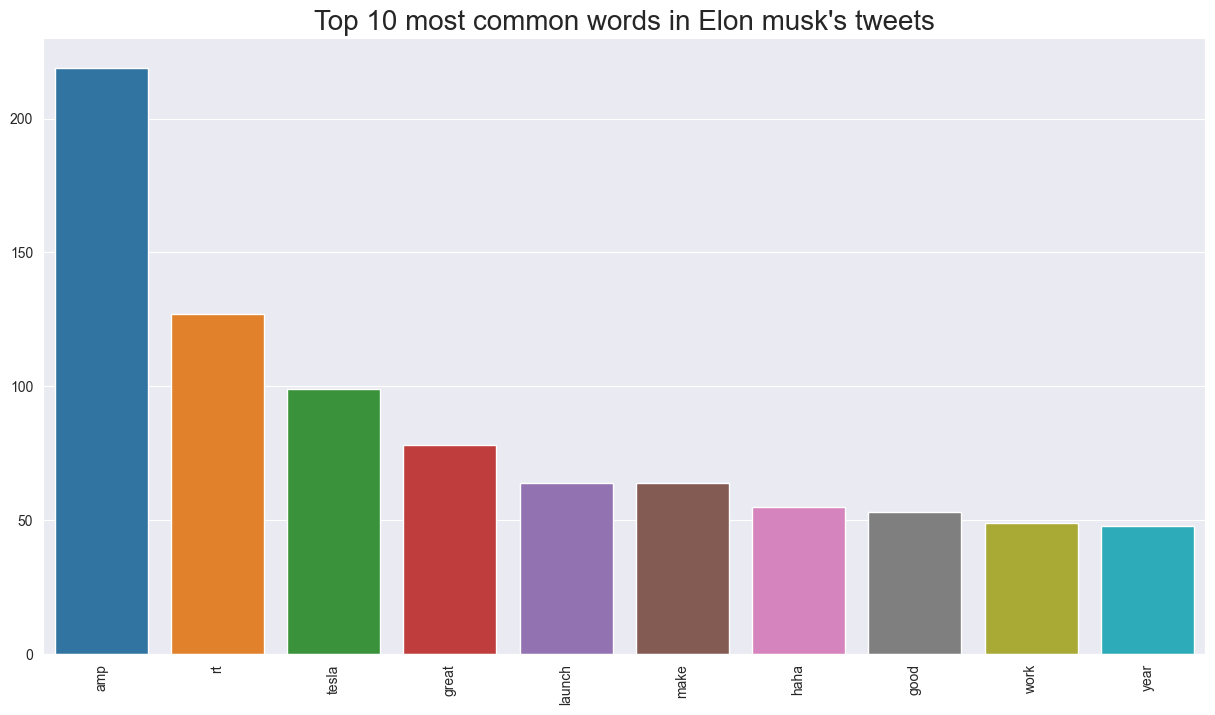

In [108]:
plt.figure(figsize=(15,8))
sns.barplot(x=freqDF.head(10).Word.values,
            y=freqDF.head(10).Freq.values)
plt.xticks(rotation=90)
plt.title('Top 10 most common words in Elon musk\'s tweets',
          fontsize=20)
plt.show()

In [109]:
def sentiment_score(text):
    global pos, neg
    pos_score = 0
    neg_score = 0
    for word in nltk.word_tokenize(text):
        if word in pos:
            pos_score += 1
        if word in neg:
            neg_score += 1
    sent_score = (pos_score-neg_score)/(len(nltk.word_tokenize(text)))
    return round(sent_score,2)

In [110]:
# get sentiment score 
data['sentiment_score'] = data.cleaned_text.apply(sentiment_score)
# get sentiment 
data['Sentiment'] = data.sentiment_score.apply(lambda x : 'Neutral' if (-0.1 <= x <= 0.1) else 'Positive' if (0.1 < x <= 0.5) else 'Very Positive' if (0.5 < x) else 'Negative' if (-0.5 <= x < -0.1) else 'Very Negative')
data.head().drop('Text',axis=1)

,cleaned_text,sentiment_score,Sentiment
0,alien,0.00,Neutral
1,ray trace cyberpunk hdr nextlevel,0.00,Neutral
2,great interview,0.50,Positive
3,doge underestimated,0.00,Neutral
4,congratulation tesla china amaze execution year,0.33,Positive


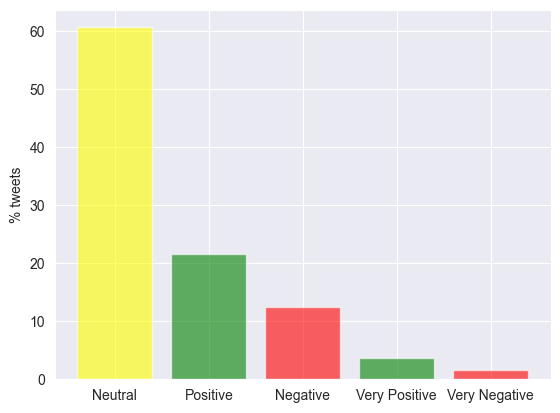

In [111]:
height = data.Sentiment.value_counts().values
index = data.Sentiment.value_counts().index
color = ['yellow','green','red','green','red']
alpha = [0.2,0.2,0.2,0.35,0.35]
plt.bar(index,height=height*100/height.sum(),color=color,alpha=0.6)
plt.ylabel('% tweets')
plt.show()

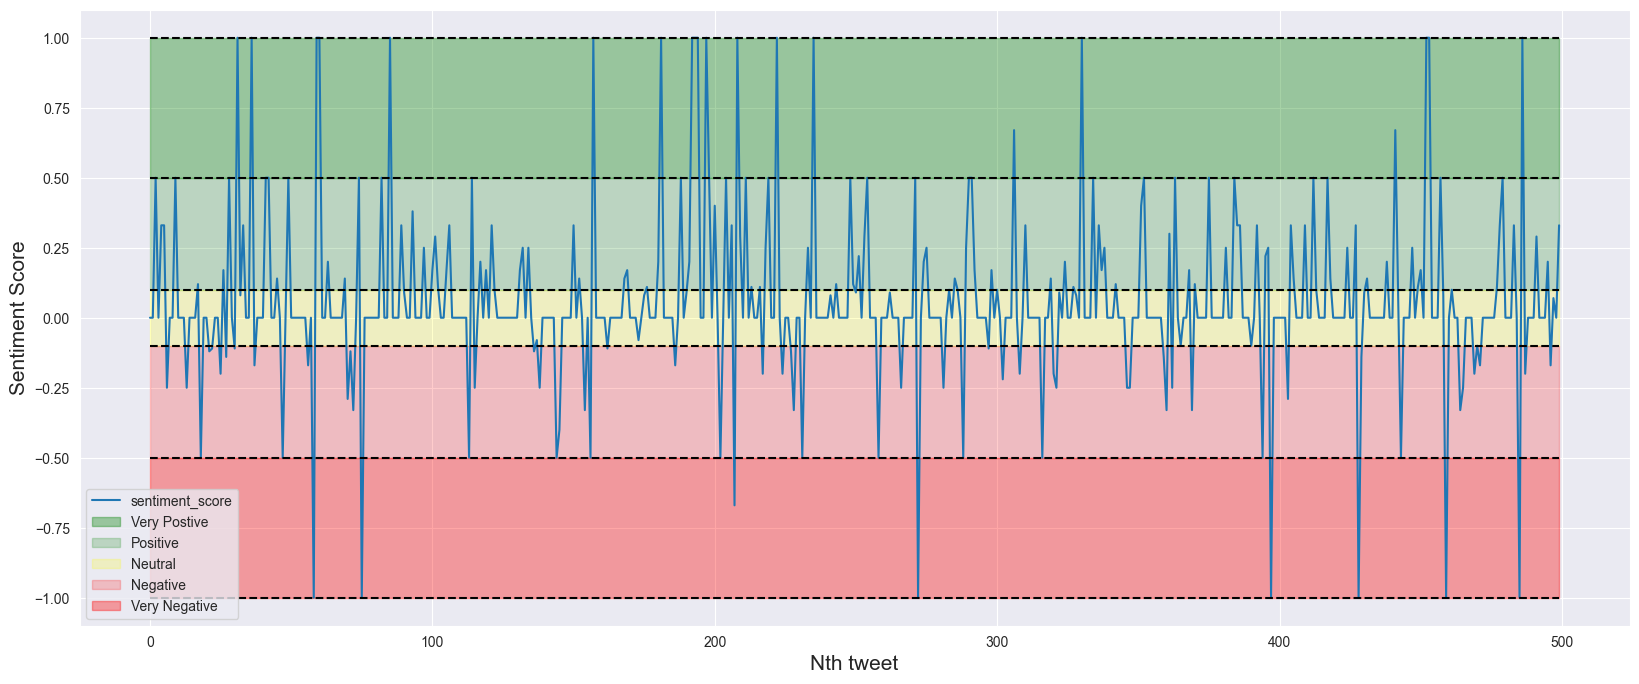

In [112]:
plt.figure(figsize=(20,8))
data.sentiment_score[:500].plot()
bord = np.array([1.0,0.5,0.1])
for x in bord:
    plt.plot((0,499),(x,x),'k--')
    plt.plot((0,499),(-x,-x),'k--')
bands = [np.concatenate((bord,bord[::-1]*-1),axis=0)[i:i+2] for i in range(np.concatenate((bord,bord[::-1]*-1),axis=0).size-1)]
labels = ['Very Postive','Positive','Neutral','Negative','Very Negative']
i = 0
for band in bands:
    color = 'yellow' if (i == 2) else 'green' if (i < 2) else 'red'
    alpha = 0.35 if (i == 0 or i == 4) else 0.2
    plt.fill_between(np.arange(500),np.ones(500)*band[0],np.ones(500)*band[-1],alpha=alpha,label=labels[i],color=color)
    i += 1
plt.xlabel('Nth tweet',fontsize=15)
plt.ylabel('Sentiment Score',fontsize=15)
plt.legend()
plt.show()

In [113]:
# features 
features = data[['cleaned_text']]
features.head()

,cleaned_text
0,alien
1,ray trace cyberpunk hdr nextlevel
2,great interview
3,doge underestimated
4,congratulation tesla china amaze execution year


In [114]:
# targets 
target = pd.get_dummies(data.Sentiment)
target.head()

,Negative,Neutral,Positive,Very Negative,Very Positive
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [115]:
# splitting data into training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(features,target,test_size=0.2,random_state=42)

In [116]:
# word vectorization 
# initializing TfidVectorizer
vec = TfidfVectorizer(min_df=0.0,max_df=1.0,ngram_range=(1,1))
vec.fit(X_train.cleaned_text.values)

TfidfVectorizer(min_df=0.0)

In [117]:
# set random state 
reproduce()
# training Neural Network 
model = Sequential()
model.add(Dense(6,input_dim=2658,
          kernel_initializer='uniform',
          activation='relu'))
model.add(Dense(5,kernel_initializer='uniform',
                activation='sigmoid'))
adam = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])
model.fit(vec.transform(X_train.cleaned_text.values).toarray(),
          Y_train.values,
          epochs=10)

Epoch 1/10
43/43 [==============================] - 4s 3ms/step - loss: 0.5601 - accuracy: 0.5988
Epoch 2/10
43/43 [==============================] - 0s 2ms/step - loss: 0.3586 - accuracy: 0.6069
Epoch 3/10
43/43 [==============================] - 0s 2ms/step - loss: 0.3154 - accuracy: 0.6069
Epoch 4/10
43/43 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.6201
Epoch 5/10
43/43 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.7731
Epoch 6/10
43/43 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.8397
Epoch 7/10
43/43 [==============================] - 0s 2ms/step - loss: 0.1091 - accuracy: 0.9180
Epoch 8/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.9407
Epoch 9/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0671 - accuracy: 0.9436
Epoch 10/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.9473


In [118]:
# predictions on testing data 
np.set_printoptions(suppress=True)
pred = model.predict(vec.transform(X_test.cleaned_text.values).toarray())
pred

11/11 [==============================] - 0s 4ms/step


array([[0.0125816 , 0.711279  , 0.03396303, 0.00019642, 0.00041692],
       [0.356215  , 0.10020053, 0.4990882 , 0.24949773, 0.36117426],
       [0.00229209, 0.1976893 , 0.7857644 , 0.00127552, 0.00604617],
       ...,
       [0.00075356, 0.9976156 , 0.0003364 , 0.00001372, 0.00002039],
       [0.00434694, 0.8457701 , 0.03542268, 0.00023458, 0.00055027],
       [0.02126362, 0.99557716, 0.00006887, 0.00004275, 0.00003305]],
      dtype=float32)

In [119]:
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1
print(f'Test accuracy of NN -> {round(accuracy_score(Y_test.values,pred)*100,2)} %')

Test accuracy of NN -> 61.99 %


## Built a sentiment classifier with testing accuracy of 61.99 % 